In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [2]:


# Define parameters
radius = 2  # Radius of the circular disk
source_point = (0.6, 1.2)  # Coordinates of the source point
source_concentration = 1  # Concentration at the source point
grid_size = 80  # Number of grid points along each axis

# Create grid
x = np.linspace(-radius, radius, grid_size)
y = np.linspace(-radius, radius, grid_size)
X, Y = np.meshgrid(x, y)

# Initialize concentration matrix
c = np.zeros((grid_size, grid_size))

# Set concentration at the source point
source_index1 = (np.abs(x - source_point[0])).argmin()
source_index2 = (np.abs(y - source_point[1])).argmin()
c[source_index1, source_index2] = source_concentration

# Construct Laplace operator matrix
L = np.zeros((grid_size**2, grid_size**2))
for i in range(grid_size):
    for j in range(grid_size):
        L[i*grid_size + j, i*grid_size + j] = 4
        if i > 0:
            L[i * grid_size + j, (i-1) * grid_size + j] = -1
        if i < grid_size - 1:
            L[i * grid_size + j, (i+1) * grid_size + j] = -1
        if j > 0:
            L[i * grid_size + j, i * grid_size + (j-1)] = -1
        if j < grid_size - 1:
            L[i * grid_size + j, i * grid_size + (j+1)] = -1
            
# Solve linear system
c_vector = c.flatten()
solution_vector = la.solve(L, c_vector)

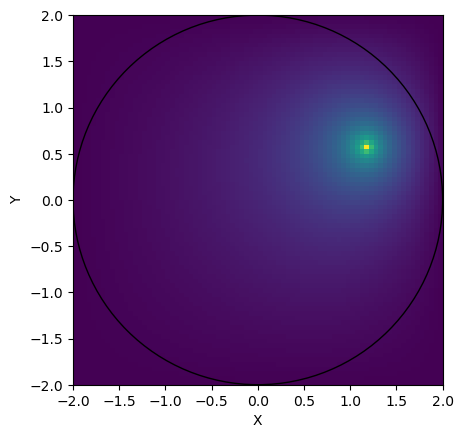

In [3]:
fig, ax = plt.subplots()
ax.imshow(solution_vector.reshape(grid_size, grid_size), origin='lower', extent=(-radius, radius, -radius, radius))
#ax.colorbar(label='Concentration')
ax.set_xlabel('X')
ax.set_ylabel('Y')
circle = plt.Circle((0, 0), radius, color='black', fill=False)
ax.add_artist(circle)


#### Leapfrog Algorithm

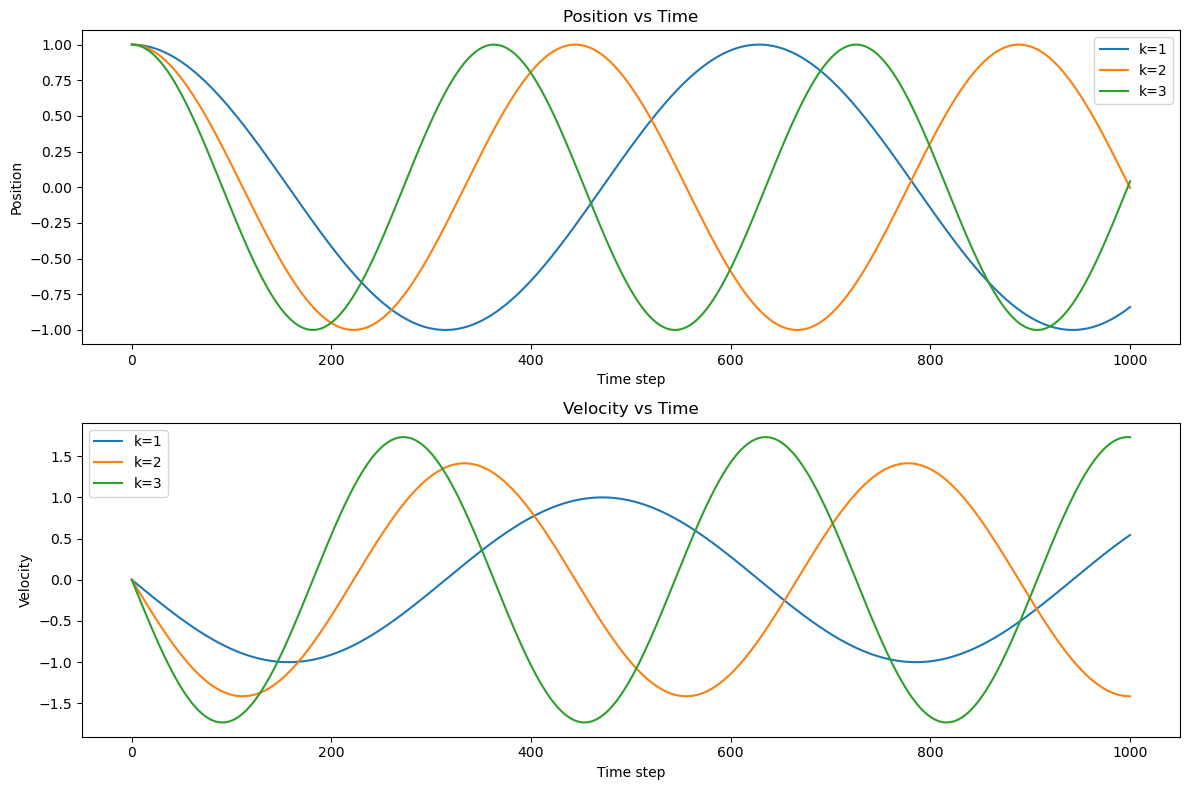

In [3]:

# Function to calculate force
def force(x, k):
    return -k * x

# Leapfrog method implementation
def leapfrog(x0, v0, k, dt, num_steps):
    positions = [x0]
    velocities = [v0]
    
    x = x0
    v = v0
    
    for _ in range(num_steps):
        v_half = v + 0.5 * dt * force(x, k)
        x += dt * v_half
        v = v_half + 0.5 * dt * force(x, k)
        
        positions.append(x)
        velocities.append(v)
        
    return positions, velocities

# Parameters
x0 = 1.0  # Initial position
v0 = 0.0  # Initial velocity
m = 1.0   # Mass
dt = 0.01 # Timestep
num_steps = 1000 # Number of steps

# Values of k
k_values = [1, 2, 3]

# Plotting
plt.figure(figsize=(12, 8))

for k in k_values:
    positions, velocities = leapfrog(x0, v0, k, dt, num_steps)
    plt.subplot(2, 1, 1)
    plt.plot(positions, label=f'k={k}')
    plt.title('Position vs Time')
    plt.xlabel('Time step')
    plt.ylabel('Position')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(velocities, label=f'k={k}')
    plt.title('Velocity vs Time')
    plt.xlabel('Time step')
    plt.ylabel('Velocity')
    plt.legend()

plt.tight_layout()
plt.show()